In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from IRLS import IRLS

# Test 1
Create data from logistic model and compare resulting parameters to the ground truth.

$X \sim N(0, I)$

$p = \sigma(\beta_0 + X \beta)$

$y_i \sim \text{Bern}(p_i)$

First test verifies the convergence of calculated $\hat\beta$ of IRLS to actual $\beta$, as the number of observations increases.

For this experiment, we fix the value of $\beta$ at $(1.0, 2.0, 3.0)'$ and change the number of observations $n$ from 50 to 500 in steps of 10. For each generated dataset we calculate the mean squared error of $\beta$ using the following formula $error_{MSE} = \frac{1}{p} \sum_i=1^p (\hat\beta_i - \beta_i)^2$. We repeat the experiment 10 times for each value of $n$, and take the mean value of $error_{MSE}$ accross these runs as the typical error for a particular value of $n$. Should our implementation work correctly, this value should decrease as the number of observations $n$ of the generated data increases. 

We fit intercept and consider $\beta_0$ to be a part of $\beta$.


In [85]:
def generate_data(n = 50, beta = [1, .5, .5]):
    X = np.random.normal(0, 1, size=(n, len(beta)-1))
    b0 = beta[0]
    b = beta[1:]
    exp_part = - (b0 + np.sum(X * b, axis=1))
    p = 1 / (1 + np.exp(exp_part))
    y = np.random.binomial(1, p, n)
    
    return X, y

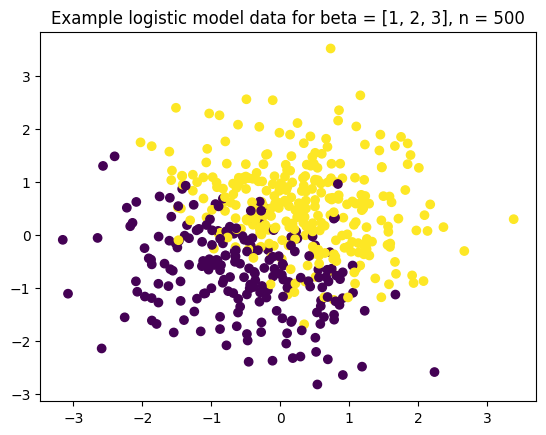

In [86]:
beta = np.array([1, 2, 3])
X, y = generate_data(500, beta = beta)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Example logistic model data for beta = [1, 2, 3], n = 500")
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error

In [96]:
n_list = [i for i in range(50, 501, 10)]
num_repeats = 10
beta = np.array([1, 2, 3])
results = []
for n in n_list:
    step_results = []
    for _ in range(num_repeats):
        X, y = generate_data(n, beta = beta)
        mse = mean_squared_error(beta, IRLS().fit(X, y).params("beta"))
        step_results.append(mse)
    step_mse = np.mean(step_results)
    results.append(step_mse)

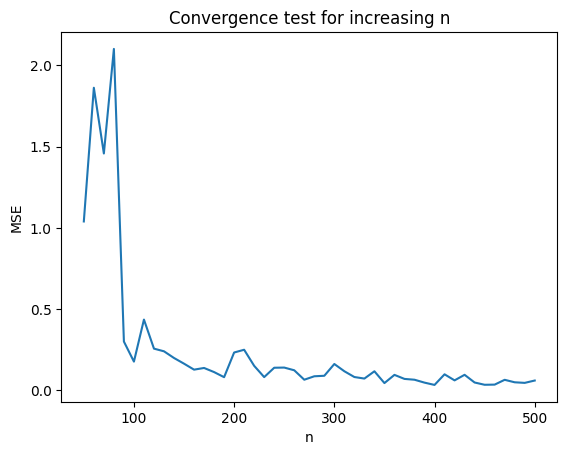

In [91]:
plt.plot(n_list, results)
plt.title("Convergence test for increasing n")
plt.xlabel("n")
plt.ylabel("MSE")
plt.show()

# Test 2
Resilience to non-logistic model data. Comparison of performance with existing implementation of logistic regression.

To test the resilience of our implementation to non-logistic model data we propose a new data generation scheme:

$n = 1000, p = 2$

$y_i \sim Bern(0.5)\text{ for } i = 1, ..., n$

$X_i \sim N(0, I), \text{when } y_i = 0$

$X_i \sim N(\mu, I), \text{when } y_i = 1$

where $\mu \in \mathbb{R}^p$ is a parameter that will be changed to test the implementation. This parameter will be set to values of type $\mu = (\mu_0, \mu_0)'$, where $\mu_0$ ranges from 0.1 to 2.0 with a step of 0.1. Next, an accuracy of the model will be calculated, by using the `predict` method on X and the accuracy will be recorded. Additionally, a reference implementation of logistic regression will be used to verify the resulting accuracies. We use `LogisticRegression` from the Python `scikit-learn` package with the parameters `fit_intercept=True` and `penalty=None`. As this data generation scheme has no intrinsic ground truth value of $\beta$, we will compare the accuracies of both implementations, to verify that our implementation works similarly to an existing implementation. For each value of $\mu$ the cycle of generating data, fitting and evaluating our implementation and a reference implementation is repeated 10 times, and the mean of the accuracies is taken.

In [105]:
def gen_scheme_bimodal(mu):
    n = 1000
    p = 2
    
    y = np.random.randint(2, size=n)
    X = np.zeros((n,p))
    
    for i, yi in enumerate(y):
        if yi == 0:
            X[i, :] = np.random.normal(0, 1,size=(p))
        else:
            X[i, :] = np.random.normal(mu, 1,size=(p))

    return X, y

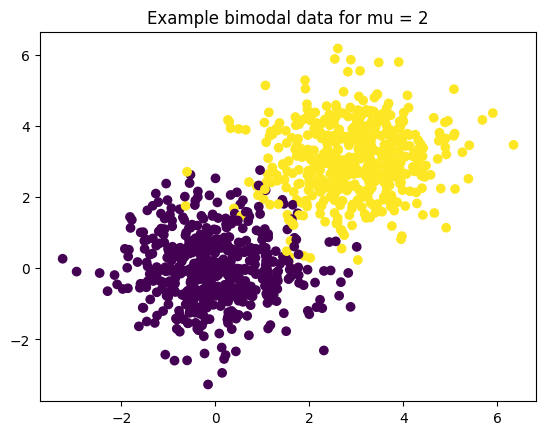

In [106]:
X, y = gen_scheme_bimodal(3)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Example bimodal data for mu = 2")
plt.show()

In [107]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [108]:
mu_list = [i/10 for i in range(1, 21)]
num_repeats = 10
results_scikit = []
results_ours   = []
for mu in mu_list:
    step_scikit = []
    step_ours   = []
    for _ in range(num_repeats):
        X, y = gen_scheme_bimodal(mu)
        step_scikit.append(accuracy_score(
            y,
            LogisticRegression(fit_intercept=True, penalty=None).fit(X, y).predict(X)
        ))
        step_ours.append(accuracy_score(
            y,
            IRLS().fit(X, y).predict(X)
        ))
    results_scikit.append(np.mean(step_scikit))
    results_ours.append(np.mean(step_ours))

In [109]:
import pandas as pd
import seaborn as sns

In [110]:
pd.DataFrame({"mu_values": mu_list, "reference": results_scikit, "implementation": results_ours})

,mu_values,reference,implementation
0,0.1,0.5346,0.5346
1,0.2,0.5592,0.5592
2,0.3,0.5910,0.5910
3,0.4,0.6141,0.6141
4,0.5,0.6379,0.6379
5,0.6,0.6651,0.6651
6,0.7,0.6911,0.6911
7,0.8,0.7155,0.7155
8,0.9,0.7342,0.7342
9,1.0,0.7606,0.7606


In [ ]:
# it's literally the same

# Test 3
Test interaction implementation by performing self-interaction of the model to allow better performance. The data generation scheme is as follows:

$n = 200, p = 2$

$X \sim N(0, I)$

$y_i \sim Bern(1 - X_{i,1}^2), \text{ when } X_{i,1}^2 \le 1$

$y_i = 0, \text{ when } X_{i,1}^2 > 1$

Two models will be fitted using our implementation. One will use the "interactions" feature of our implementation to induce a "self-interaction" of the first feature of $X$. This will be equivalent to adding another column that will be equal to the square of the first one. This generation scheme has no clear linear decision boundary in the original space, however in the augmented space it is possible to fit.

To test the interactions feature of our implementation we will fit our model twice for each generated data, once with the feature enabled, and once without. Then we will compare the accuracies, after repeating the experiment 10 times.

In [10]:
def generate_data_polynomial(n = 200):   
    # N(0, 1) distribution
    X = np.random.normal(size=(n,2))
    
    # generate 1 class near 0
    y = (np.random.uniform(size=(n)) > X[:, 0]**2) + 0
    
    return X, y

In [11]:
X_poly, y_poly = generate_data_polynomial(200)

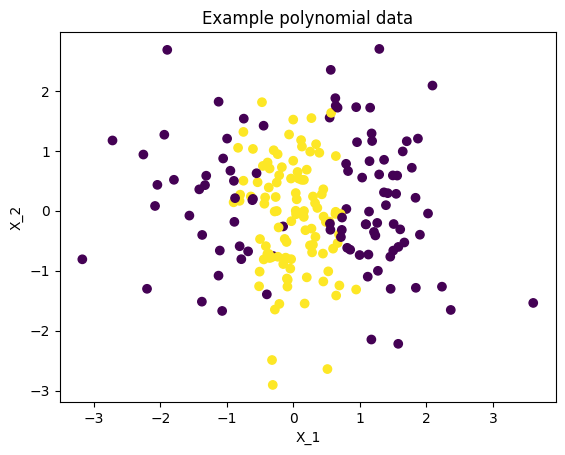

In [113]:
plt.scatter(X_poly[:,0], X_poly[:,1], c=y_poly)
plt.title("Example polynomial data")
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.show()

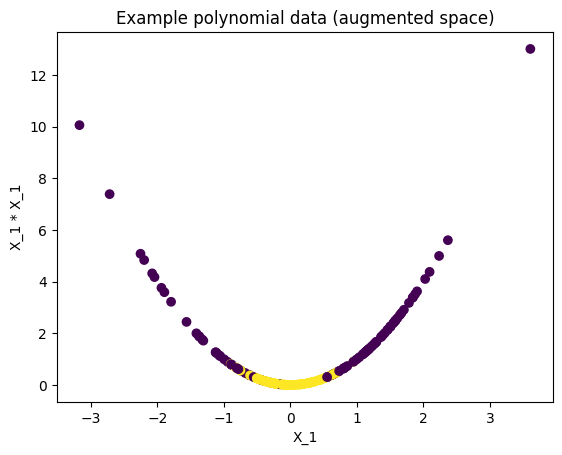

In [114]:
plt.scatter(X_poly[:,0], X_poly[:,0]*X_poly[:,0], c=y_poly)
plt.title("Example polynomial data (augmented space)")
plt.xlabel("X_1")
plt.ylabel("X_1 * X_1")
plt.show()

In [120]:
step_augmented = []
step_original   = []
for _ in range(num_repeats):
    X, y = generate_data_polynomial(200)
    step_augmented.append(accuracy_score(
        y,
        IRLS(interactions=[[0,0]]).fit(X, y).predict(X)
    ))
    step_original.append(accuracy_score(
        y,
        IRLS().fit(X, y).predict(X)
    ))
data = pd.DataFrame({"augmented": step_augmented, "original": step_original})

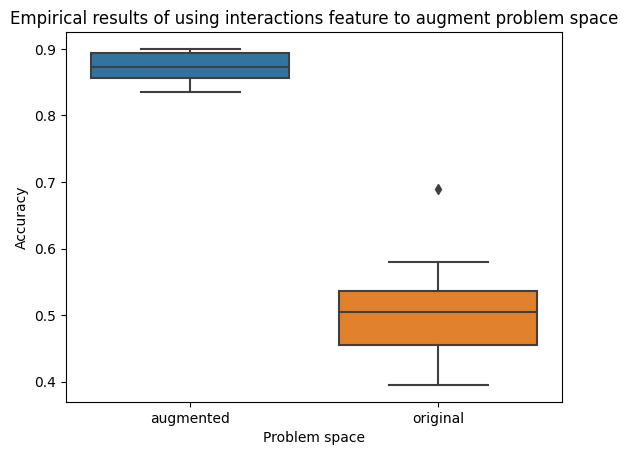

In [125]:
sns.boxplot(data.melt(var_name="Problem space", value_name="Accuracy"), y="Accuracy", x="Problem space")
plt.title("Empirical results of using interactions feature to augment problem space")
plt.show()

# Test 4
We test on data inspired by the famous XOR problem of machine learning. We add noise to prevent linear separability in the augmented space, as our implementation does not have regularization to cope with such a case.

$n = 200, p = 2$

$X \sim N(0, I)$

Define helper random variable $\gamma_i \sim N(0, 0.5)$

$y_i = 1, \text{ when } \gamma_i > X_{i,1} \cdot X_{i,2}$

$y_i = 0, \text{ otherwise }$

Similarly to test 3, we fit and evaluate models with different configurations. We test no interaction, self-interaction and cross-interaction. We repeat the setup 10 times.

The expected result is that only cross-interaction achieves significantly better results than no interaction setup.

In [169]:
def generate_data_xor(n = 100):   
    # N(0, 1) distribution
    X = np.random.normal(size=(n,2))
    
    # generate 1 class near 0
    y = (np.random.normal(0, 0.5, size=n) > X[:, 0] * X[:, 1]) + 0
    
    return X, y

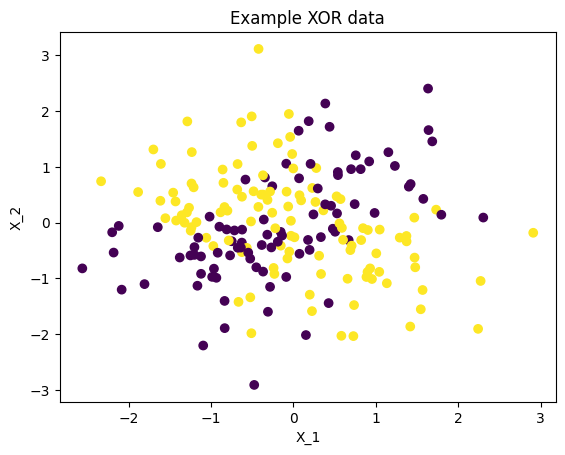

In [171]:
X_xor, y_xor = generate_data_xor(200)
plt.scatter(X_xor[:,0], X_xor[:,1], c=y_xor)
plt.title("Example XOR data")
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.show()

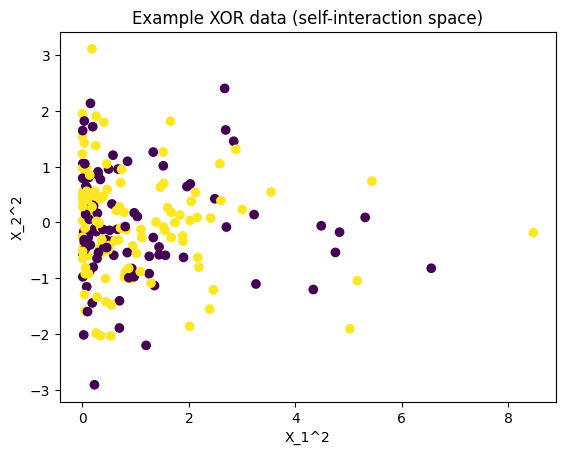

In [180]:
plt.scatter(X_xor[:,0]*X_xor[:,0], X_xor[:,1]*X_xor[:,1], c=y_xor)
plt.title("Example XOR data (self-interaction space)")
plt.xlabel("X_1^2")
plt.ylabel("X_2^2")
plt.show()

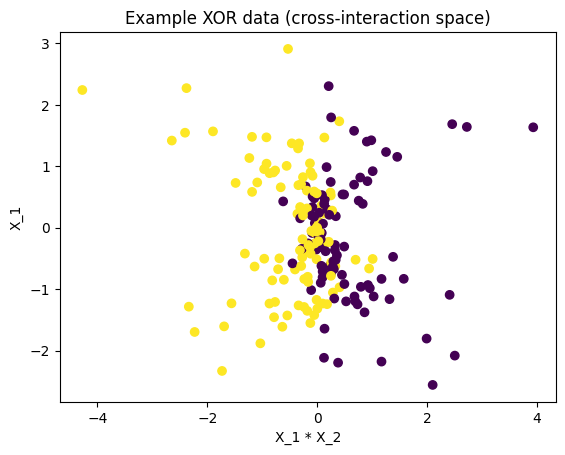

In [173]:
plt.scatter(X_xor[:,0]*X_xor[:,1], X_xor[:,0], c=y_xor)
plt.title("Example XOR data (cross-interaction space)")
plt.xlabel("X_1 * X_2")
plt.ylabel("X_1")
plt.show()

In [184]:
a = []
b = []
c = []
for _ in range(num_repeats):
    X, y = generate_data_xor(200)
    a.append(accuracy_score(
        y,
        IRLS().fit(X, y).predict(X)
    ))
    b.append(accuracy_score(
        y,
        IRLS(interactions=[[0,0]]).fit(X, y).predict(X)
    ))
    c.append(accuracy_score(
        y,
        IRLS(interactions=[[0,1]]).fit(X, y).predict(X)
    ))
data = pd.DataFrame({"cross-interaction": c, "self-interaction": b, "original": a})

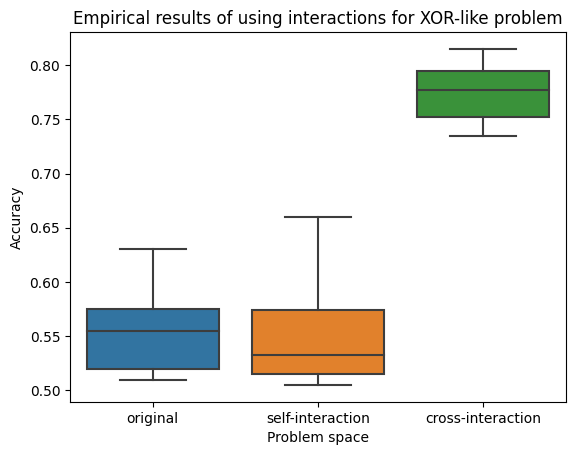

In [188]:
sns.boxplot(
    data.melt(var_name="Problem space", value_name="Accuracy"),
    y="Accuracy",
    x="Problem space",
    order=["original", "self-interaction", "cross-interaction"]
)
plt.title("Empirical results of using interactions for XOR-like problem")
plt.show()